<a href="https://colab.research.google.com/github/olumideaeo/Machine-Learning-Collection/blob/master/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install text_hammer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install gensim==3.8.3
!pip install keras --upgrade
!pip install pandas --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
# importing the dataset 
df_raw=pd.read_csv('/content/drive/MyDrive/CoLI-Kanglish/rawtext.txt')
df_train = pd.read_csv('/content/drive/MyDrive/CoLI-Kanglish/Train_Kanglish.csv')
df_test = pd.read_csv('/content/drive/MyDrive/CoLI-Kanglish/Test_withoutLabels_Kanglish.csv')


In [ ]:
df_raw

,text
0,klm
1,movie nalli continuation illa
2,nijavagalu super guru
3,concept making camera work yalha changi but ma...
4,nice but voice yar act madidaro avr atrane dub...
...,...
72129,dandapinda charche ivra mane
72130,siddaramaiah boss fan
72131,power boss fan
72132,aasthi koti madoke farmer name politicians


In [ ]:
df_train

,word,tag
0,anusthu,kn
1,woww,en
2,staying,en
3,near,en
4,hostel,en
...,...,...
14842,hiremadtara,en-kn
14843,solutionila,en-kn
14844,accessmadkoli,en-kn
14845,glasshakisi,en-kn


In [ ]:
df_train.iloc[:,-1:]

,tag
0,kn
1,en
2,en
3,en
4,en
...,...
14842,en-kn
14843,en-kn
14844,en-kn
14845,en-kn


In [ ]:
df_train['tag'].value_counts()

kn          6526
en          4469
other       1663
en-kn       1379
name         708
location     102
Name: tag, dtype: int64

In [ ]:
df_train.drop_duplicates(inplace = True, keep = 'first')

In [ ]:
df_train.describe(include = 'all')

,word,tag
count,14769,14769
unique,14762,6
top,mindalli,kn
freq,2,6494


Text(0.5, 1.0, 'Distribution of tags in dataset')

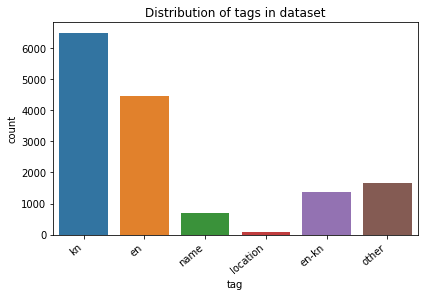

In [ ]:
import seaborn as sns
ax = sns.countplot(data = df_train, x = 'tag')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=10)
plt.rcParams["figure.figsize"] = (15, 8)
plt.tight_layout()
plt.title('Distribution of tags in dataset')

In [ ]:
documents = [_text.split() for _text in df_train.word] 

In [ ]:
!pip uninstall tensorflow

In [ ]:
!pip install tf-nightly

In [ ]:
# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [ ]:
w2v_model = gensim.models.word2vec.Word2Vec(window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT,
                                            size=W2V_SIZE,
                                            workers=8)

In [ ]:
%%time
documents = df_train.word 

CPU times: user 157 µs, sys: 0 ns, total: 157 µs
Wall time: 163 µs


In [ ]:
w2v_model = gensim.models.word2vec.Word2Vec(window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT,
                                            size=W2V_SIZE, 
                                            workers=8)

In [ ]:
w2v_model.build_vocab(documents)

In [ ]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30


In [ ]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 2.42 s, sys: 106 ms, total: 2.53 s
Wall time: 1.85 s


(563722, 3364512)

In [ ]:
from keras_preprocessing.sequence import pad_sequences

In [ ]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.word)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 14763
CPU times: user 223 ms, sys: 9.73 ms, total: 233 ms
Wall time: 431 ms


In [ ]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.word), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.word), maxlen=SEQUENCE_LENGTH)

CPU times: user 318 ms, sys: 22 ms, total: 340 ms
Wall time: 640 ms


In [ ]:
labels = df_train.tag.unique().tolist()
labels

['kn', 'en', 'name', 'location', 'en-kn', 'other']

In [ ]:
df_test

,word
0,alla
1,kopista
2,baruthe
3,coolagiru
4,madhuswamy
...,...
4580,kalena
4581,horg
4582,tarovanthaa
4583,banglore


In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train.tag.tolist())

y_train = encoder.transform(df_train.tag.tolist())
#y_test = encoder.transform(df_test.tag.tolist())

y_train = y_train.reshape(-1,1)
#y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)

y_train (14769, 1)


In [ ]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(14763, 300)


In [ ]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          4428900   
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 4,589,401
Trainable params: 160,501
Non-trainable params: 4,428,900
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [ ]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
13/13 [==============================] - ETA: 0s - loss: -0.0500 - accuracy: 0.0415

13/13 [==============================] - 224s 16s/step - loss: -0.0500 - accuracy: 0.0415 - val_loss: -1.1356 - val_accuracy: 0.7718 - lr: 0.0010
Epoch 2/8
13/13 [==============================] - ETA: 0s - loss: -6.5998 - accuracy: 0.0169 

13/13 [==============================] - 211s 16s/step - loss: -6.5998 - accuracy: 0.0169 - val_loss: -2.4379 - val_accuracy: 0.7718 - lr: 0.0010
Epoch 3/8
13/13 [==============================] - ETA: 0s - loss: -10.1978 - accuracy: 0.0169 

13/13 [==============================] - 224s 17s/step - loss: -10.1978 - accuracy: 0.0169 - val_loss: -3.1766 - val_accuracy: 0.7718 - lr: 0.0010
Epoch 4/8
13/13 [==============================] - ETA: 0s - loss: -12.3195 - accuracy: 0.0169 

13/13 [==============================] - 197s 15s/step - loss: -12.3195 - accuracy: 0.0169 - val_loss: -3.6299 - val_accuracy: 0.7718 - lr: 0.0010
Epoch 5/8
13/13 [==============================] - ETA: 0s - loss: -13.8346 - accuracy: 0.0169 

13/13 [==============================] - 207s 15s/step - loss: -13.8346 - accuracy: 0.0169 - val_loss: -4.0139 - val_accuracy: 0.7718 - lr: 0.0010
Epoch 6/8
13/13 [==============================] - ETA: 0s - loss: -15.1808 - accuracy: 0.0169 

13/13 [==============================] - 216s 17s/step - loss: -15.1808 - accuracy: 0.0169 - val_loss: -4.3789 - val_accuracy: 0.7718 - lr: 0.0010
Epoch 7/8
13/13 [==============================] - ETA: 0s - loss: -16.4876 - accuracy: 0.0169 

13/13 [==============================] - 201s 16s/step - loss: -16.4876 - accuracy: 0.0169 - val_loss: -4.7250 - val_accuracy: 0.7718 - lr: 0.0010
Epoch 8/8
13/13 [==============================] - ETA: 0s - loss: -17.7305 - accuracy: 0.0169 

13/13 [==============================] - 204s 15s/step - loss: -17.7305 - accuracy: 0.0169 - val_loss: -5.0642 - val_accuracy: 0.7718 - lr: 0.0010
CPU times: user 43min 56s, sys: 3min 52s, total: 47min 48s
Wall time: 28min 25s
